In [1]:
using Pkg
Pkg.activate(".")

  Activating new environment at `~/Documents/Github2/Physics-215-Julia/Session 1 - HPC and the Julia Frame/Project.toml`


### KR1: Use ```@code_*``` to examine a simple function. The `*` is replaceable by `native`, `typed`, `warntype`, and others. Discover them.

Let us first define a simple function. Written below is a function that takes two variables and outputs their sum.

In [2]:
function f(x,y) x + y end

f (generic function with 1 method)

In [3]:
@code_native f(1,2)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[2]:1 within `f'
; │┌ @ int.jl:87 within `+'
	leaq	(%rdi,%rsi), %rax
; │└
	retq
	nopw	%cs:(%rax,%rax)
; └


In [4]:
@code_typed f(1.1,2)

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, y)::Float64
│   %2 = Base.add_float(x, %1)::Float64
└──      return %2
) => Float64

In [5]:
@code_warntype f(1.1,2)

Variables
  #self#::Core.Const(f)
  x::Float64
  y::Int64

Body::Float64
1 ─ %1 = (x + y)::Float64
└──      return %1


In [6]:
@code_lowered f(1,2)

CodeInfo(
1 ─ %1 = x + y
└──      return %1
)

In [7]:
@code_llvm f(1,2)

;  @ In[2]:1 within `f'
define i64 @julia_f_1801(i64 signext %0, i64 signext %1) {
top:
; ┌ @ int.jl:87 within `+'
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


Now all of these `macro` functions are new to me so I will just to explain what I understood from our class discussion and some basic googling. These `macro` functions simply convert your `code` into another form of `code` that has a different expression that I believe is more readable by the machine. Using these `@code_*` macros also show us for example, the data types of our inputs, the step-by-step process inside the function and what the output is. In Julia, there are 5 `@code_*` marcos which are `native`, `typed`, `warntype`, `lowered`, and `llvm`. These difference macro functions are I believe just different formms of how the code is being implemented by Julia.

It is also important for us to at least know how to implement these macros for cases when we are unsure of the data types of the processes that are happening inside a function. We can see for example in the code blocks above that the `code_*` marcos return `i64` and `float64` if our inputs are integers or floats for example. It also tells us the process that is being done. For example, in ` %2 = add i64 %1, %0`, we see that the function adds out inputs that are stored or located in `%1` and `%0`.

### KR2: Demonstrate that Julia is able to determine constants in codes.

Let us create a new function `g(x)` that takes a single number then performs a sequence of multiplication and division

In [8]:
function g(x)
    a = sqrt(5) * x
    return exp(2) / a
end

g (generic function with 1 method)

In [9]:
@code_warntype g(1.1)

Variables
  #self#::Core.Const(g)
  x::Float64
  a::Float64

Body::Float64
1 ─ %1 = Main.sqrt(5)::Float64
│        (a = %1 * x)
│   %3 = Main.exp(2)::Core.Const(7.38905609893065)
│   %4 = (%3 / a)::Float64
└──      return %4


In [10]:
@code_llvm  g(1.1)

;  @ In[8]:1 within `g'
define double @julia_g_1853(double %0) {
top:
;  @ In[8]:2 within `g'
; ┌ @ float.jl:332 within `*'
   %1 = fmul double %0, 0x4001E3779B97F4A8
; └
;  @ In[8]:3 within `g'
; ┌ @ float.jl:335 within `/'
   %2 = fdiv double 0x401D8E64B8D4DDAE, %1
; └
  ret double %2
}


Now the important part of the result of our `@code_llvm` are the following:
```
%1 = fmul double %0, 0x4001E3779B97F4A8
%2 = fdiv double 0x401D8E64B8D4DDAE, %1
```
Now we see that `%1` represents the first line of our function which is `sqrt(5) * x`. We also see that the constant `sqrt(5)`is stored in a memory location with value `0x4001E3779B97F4A8`. Now what Julia does is if it sees an expression that does not have a variable where it can be simplified into a single constant value, that value will be stored somewhere so that every time that specific value is needed, Julia will just pull the value from the storage instead of computing it again. This can also be seen in the next line where the value of `exp(2)` is now represented by `0x401D8E64B8D4DDAE`.

In [11]:
g_alt(x) = x*x

g_alt (generic function with 1 method)

In [12]:
@code_llvm g_alt(1)

;  @ In[11]:1 within `g_alt'
define i64 @julia_g_alt_1879(i64 signext %0) {
top:
; ┌ @ int.jl:88 within `*'
   %1 = mul i64 %0, %0
; └
  ret i64 %1
}


Looking at our `g_alt()` function, since we don't have a constant inside, we must then perform the operation inside the function.

### KR3: Demonstrate Julia's type-inference and multiple dispatch.

Now before we start creating functions, we must check first if there is already an exisiting Julia function that uses the same name. For example, if we want to create a named `measure` we must first check if it is already existing. We can do this by using the help command in Julia.

In [13]:
?measure

search:

Couldn't find measure
Perhaps you meant merge


No documentation found.

Binding `measure` does not exist.


We see that there are no built-in Julia functions that have the name measure. We also see that Julia gives us possible suggestions of functions that are similar to what we searched. Let us say for example, we plan on making a function with name `exp`, upon checking, we apparently cannot use `exp` as a function name since there is already a pre-exisiting function with that name.

In [14]:
?exp

search: exp exp2 Expr expm1 exp10 export exponent expanduser ExponentialBackOff



```
exp(x)
```

Compute the natural base exponential of `x`, in other words $e^x$.

# Examples

```jldoctest
julia> exp(1.0)
2.718281828459045
```

---

```
exp(A::AbstractMatrix)
```

Compute the matrix exponential of `A`, defined by

$$
e^A = \sum_{n=0}^{\infty} \frac{A^n}{n!}.
$$

For symmetric or Hermitian `A`, an eigendecomposition ([`eigen`](@ref)) is used, otherwise the scaling and squaring algorithm (see [^H05]) is chosen.

[^H05]: Nicholas J. Higham, "The squaring and scaling method for the matrix exponential revisited", SIAM Journal on Matrix Analysis and Applications, 26(4), 2005, 1179-1193. [doi:10.1137/090768539](https://doi.org/10.1137/090768539)

# Examples

```jldoctest
julia> A = Matrix(1.0I, 2, 2)
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

julia> exp(A)
2×2 Matrix{Float64}:
 2.71828  0.0
 0.0      2.71828
```


Now, let us define again a simple function.

In [15]:
func(x,y) = x + y

func (generic function with 1 method)

Notice that we have created a `generic function with 1 method`. A Julia function can have different ways of implementation and these implementations are called methods. Let us update our `func` function, such that, if both numbers that are inserted are integers, we will take their product instead of sum. To do this, we just write another `method` for our function.

In [16]:
func(x::Int, y::Int) = x * y

func (generic function with 2 methods)

The function has now been updated to have 2 methods, 1 method that takes the sum of any input (assuming of course that its a number) and the second method takes the product if both inputs are integers. Let us test it out.

In [17]:
println(func(1.0, 2.0))
println(func(1.0, 2))
println(func(1, 2.0))
println(func(1, 2))

3.0
3.0
3.0
2


To check all methods for our function `func`, we use the `methods()` function

In [18]:
methods(func)

# 2 methods for generic function "func":
[1] func(x::Int64, y::Int64) in Main at In[16]:1
[2] func(x, y) in Main at In[15]:1

### KR4: Show the difference, if any, between your own sum function `my_sum(x::Vector)` and `@time`. Use a `for`-loop for your customized sum function.

In [19]:
function my_sum(x::Vector)
    s = zero(eltype(x))
    for i in x s = s + i end
    return s
end

my_sum (generic function with 1 method)

The `my_sum()` function only accepts 1D arrays. To make this accept 2D or more matrices, we can simply remove the `::Vector` specification for our `x` variable. Notice also that we used `eltype()` to make sure that the data type of our placeholder for sum is the same as the data type of our list. For example, let us take the sum of the vector below:

In [20]:
trial_vector = [1, 2, 3.1, 4+im]

4-element Vector{ComplexF64}:
 1.0 + 0.0im
 2.0 + 0.0im
 3.1 + 0.0im
 4.0 + 1.0im

Notice that initially out list has different data types to begin with but what Julia did was made them all into Complex numbers to make sure that no data is lost. If for example we have integers and floats in our list, Julia will convert the data types of all elements to float. So getting the sum below, we see that the result is also a complex number, the same as the data type of the elements of our input list.

In [21]:
my_sum(trial_vector)

10.1 + 1.0im

Now let us generate a list of random numbers using the `rand` function and use `@time` to measure the time it takes for our function to get the sum.

In [22]:
x = rand(10_000)
@time my_sum(x)

  0.012306 seconds (8.19 k allocations: 447.076 KiB, 99.71% compilation time)


4983.212197999806

In [23]:
@time my_sum(x)

  0.000037 seconds (1 allocation: 16 bytes)


4983.212197999806

Notice that we have ran the `@time` macro twice. The first use of `@time` compiles the function first and uses a significant amount of time and memory, while the second use of `@time` now has a significant drop in runtime and memory allocation. So note that when profiling and timing Julia codes, we usually disregard the first time running and record the second one instead.

Now let us compare the time it takes for the built-in function `sum` to solve for the sum of all elements of the vector `x`.

In [24]:
@time sum(x)

  0.108486 seconds (76.44 k allocations: 4.518 MiB, 18.13% gc time, 99.95% compilation time)


4983.212197999798

In [25]:
@time sum(x)

  0.000013 seconds (1 allocation: 16 bytes)


4983.212197999798

In [26]:
x_big = rand(100_000_000);

In [27]:
@time my_sum(x_big)

  0.242694 seconds (1 allocation: 16 bytes)


5.000336641679063e7

In [28]:
@time sum(x_big)

  0.116134 seconds (1 allocation: 16 bytes)


5.0003366416782334e7

If we compare the time it takes to get the sum of a list with 10,000 values, we wouldn't notice any noticeable difference in the speed of the custom function `my_sum(x)` and the built-in function `sum(x)`. So what we can instead is check the function for bigger arrays. 

Looking at our values for time it takes the sum of an array with 100_000_000 elements, we can see that the built-in function outperforms the custom function (`0.116134 s` vs. `0.242694 s`)

### KR5: Replicate plotting the Mandelbrot. Use a separate file `Mandelbrot.jl` to contain the function code. Use `include()` function to load the file.

For this part, I used the discussion of Mandelbrot set of the book Computational Physics by Mark Newmann to create the `mandelbrot.jl` notebook. The Mandelbrot set is defined by the book as follows:

Consider the equation $z' = z^2 + c$, where `z` is a complex number and `c` is a complex constant. For any given value of `c`, this equation turns an input number `z` into an output number `z'`. The definition of the Mandelbrot involves the repeated iteration of this equation. Also note that if the magnitude `|z|` of the resulting value is ever greater than 2, then the point in the complex plane at position `c` is not in the Mandelbrot set, otherwise it is in the set.

In [29]:
include("Mandelbrot.jl")

plot_mandelbrot (generic function with 2 methods)

In [30]:
?mandelbrot

search: mandelbrot plot_mandelbrot



mandelbrot(c,N)

This function computes the number of iterations of the equation `z' = z^2 + c` (where c is a complex constant) before the complex number z becomes greater than 2. Note that the value of z is initialized as `z = c`.


What we did above was import our function for the Mandelbrot Set. The functions looks like this:

```
function mandelbrot(c,n)
    z = 0
    for i in 1:n
        if abs(z) > 2 return n-1 end
        z = z^2 + c 
    end
    return n
end
```

I also put the plotting function inside the `Mandelbrot.jl` file to reduce the number of files needed to import.

In [31]:
?plot_mandelbrot

search: plot_mandelbrot



plot_mandelbrot((xrange,yrange), n)

Plots the mandelbrot set inside the interval specified.


In [32]:
using Plots

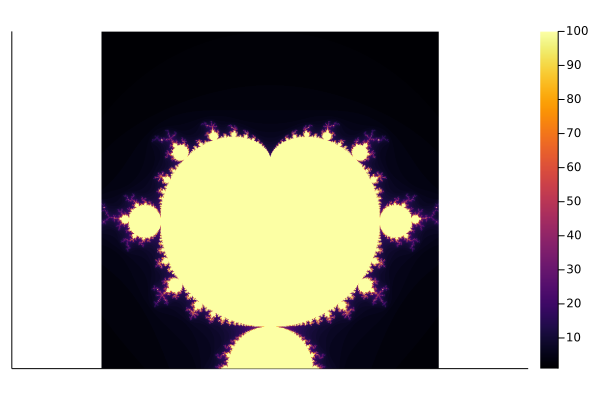

In [33]:
plot_mandelbrot((-1.0,1.0), 1000)

### KR6: Plot of the time it takes for the function to run using `@time` macro for the given grid size `n`.

Let us now try to measure the time it takes to create a mandelbrot set for different grid size `n` and also observe the resulting plots.

  0.001355 seconds (1.29 k allocations: 109.586 KiB)


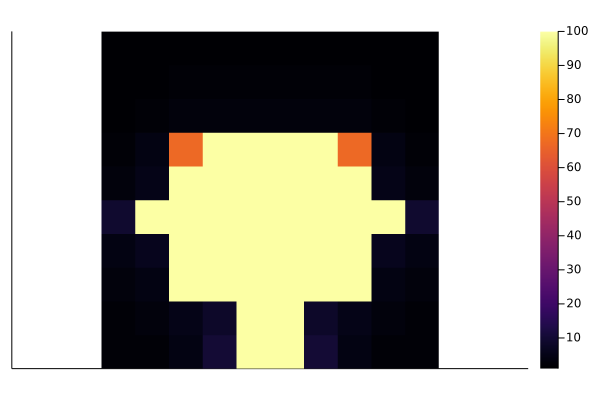

In [34]:
@time plot_mandelbrot((-1.0,1.0), 10)

  0.008407 seconds (1.65 k allocations: 279.867 KiB)


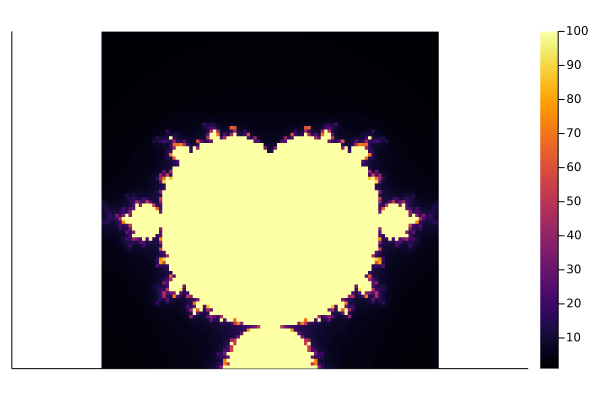

In [35]:
@time plot_mandelbrot((-1.0,1.0), 100)

  0.802555 seconds (5.25 k allocations: 15.531 MiB, 12.21% gc time)


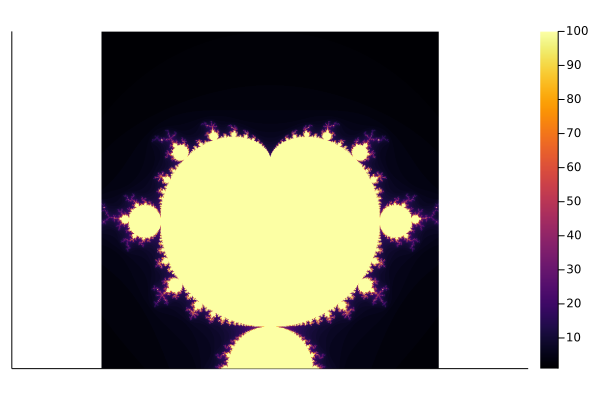

In [36]:
@time plot_mandelbrot((-1.0,1.0), 1000)

 18.508044 seconds (21.26 k allocations: 382.413 MiB, 0.29% gc time)


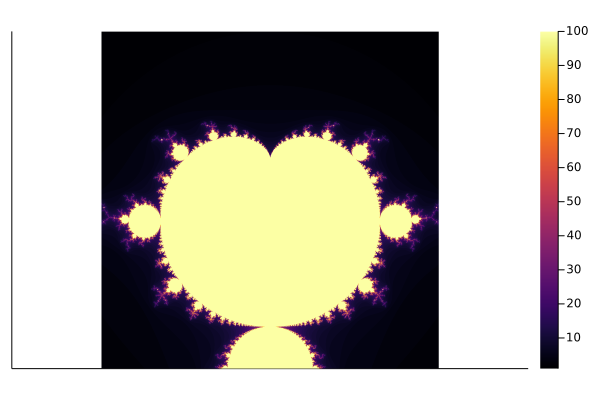

In [37]:
@time plot_mandelbrot((-1.0,1.0), 5000)

We see that increasing the grid size makes our code run a little bit longer. But if we look at the results, we see that having a larger grid size creates a more defined Mandelbrot set especially if we look at it closely.

  0.023343 seconds (1.65 k allocations: 279.867 KiB)


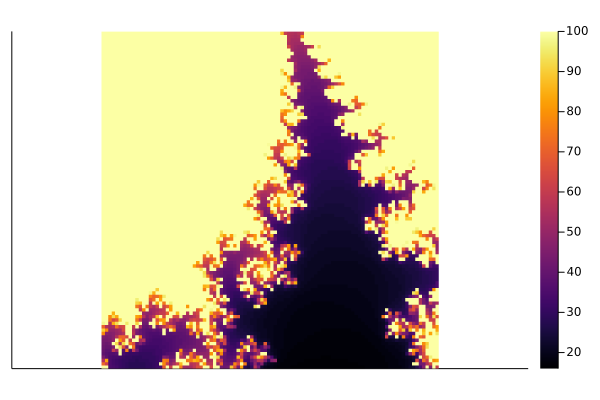

In [38]:
@time plot_mandelbrot((-0.55,-0.5), 100)

  1.237077 seconds (5.25 k allocations: 15.531 MiB)


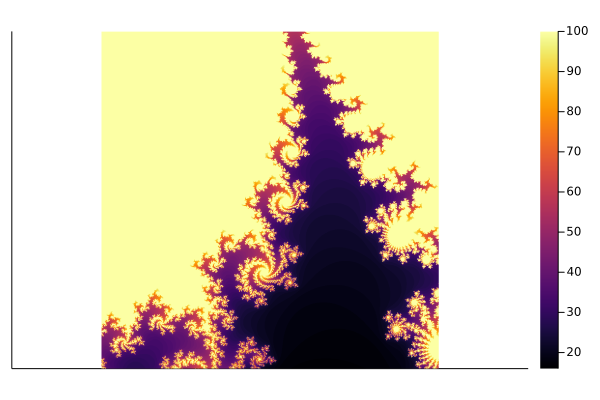

In [39]:
@time plot_mandelbrot((-0.55,-0.5), 1000)

We can actually make a line plot of `time elapsed vs. size n` to see the relationship of the two variables. Here, we use the `@timed` macro so that we can store both the time elapsed and the memory allocation.

In [56]:
nvals = 100:100:3_000
vals = [@timed plot_mandelbrot((-0.55,-0.5), n)  for n in nvals]
timevals = [ x[2] for x in vals ]
memvals = [ x[3] for x in vals ];

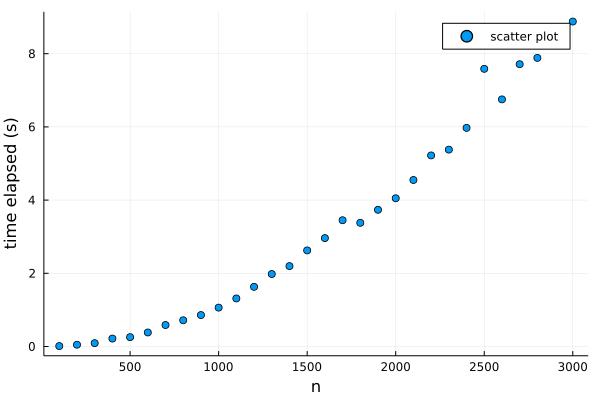

In [58]:
plot(nvals, timevals, seriestype = :scatter, label = "scatter plot")
xlabel!("n")
ylabel!("time elapsed (s)")

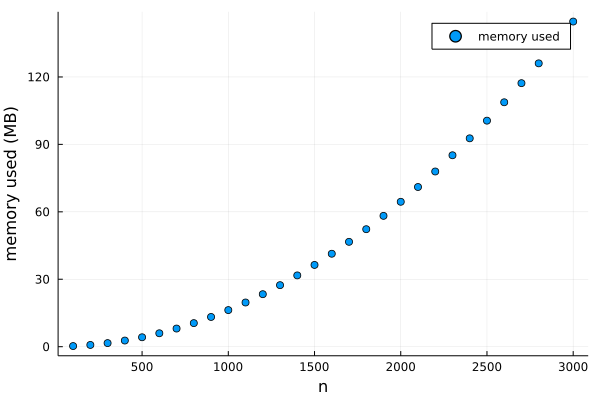

In [59]:
plot(nvals, memvals/1e6, seriestype = :scatter, label = "memory used")
xlabel!("n")
ylabel!("memory used (MB)")

### KR7: Disuss the computational complexity of the Madelbrot function you made based on KR5. What is the best `@time` output to use for this?

The plots above show the time complexity of our code. We can see that based on our `time elapsed (s) vs. n` that we have a `O(n^2)` time complexity. We can also see the trend in our memory used vs. n plot. The reason for this is the time elapsed is only dependent on our grid size `n^2` since we have fixed the number of iterations for our mandelbrot set. We also see some spikes in our plot for the time elapsed which is likely because of running multiple apps in the background such as discord and safari while the code is running.

Now, what we can do to show this is to fit a curve in our time vs. iteration plot. To do this, I used the `CurveFit` package and used the `power_fit(x,y)` function to get the coefficient of our curve with the form `y = a*x^b`

In [60]:
using CurveFit

In [62]:
a,b = power_fit(nvals, timevals)

(1.3962542502925283e-6, 1.9648543762470299)

We see that the equation of our curve is `y = 1.4e-6 * x^1.96` which basically confirms our theory above that the complexity of our code is of the form `O(n^2)`.

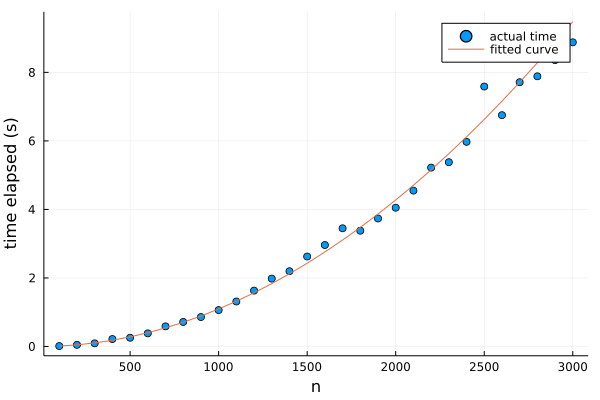

In [75]:
fitted_curve = a.*collect(nvals).^b

plot(nvals, timevals, seriestype = :scatter, label = "actual time")
plot!(nvals, fitted_curve, label = "fitted curve")
xlabel!("n")
ylabel!("time elapsed (s)")

If we wanted to, we can actually vary the number of iterations inside the mandelbrot function itself and that would increase the complexity to `O(n^2 * N)` where `N` is the number of iterations inside the mandelbrot function